# Tracking a moving stystem

We consider a state-space model of the form
$$
\begin{aligned}
    p(z_t \vert z_{t-1}) &= {\cal N}(z_t \vert F z_{t-1}, Q_t)\\
    p(y_t \vert z_t) &= \text{St}(y_t \vert  H_t z_t, R_t, \nu)
\end{aligned}
$$

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

from rebayes_mini import callbacks
from rebayes_mini.datasets import linear_ssm
from rebayes_mini.methods import student_t_filter as stf
from rebayes_mini.methods import gauss_filter as kf
from rebayes_mini.methods import generalised_bayes_filter as gbf

2023-11-27 16:49:42.948137: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

plt.rcParams["font.size"] = 14

In [3]:
key = jax.random.PRNGKey(3141592)

## Multiple samples

In [4]:
import numpy as np
import seaborn as sns
from functools import partial

In [5]:
delta = 0.1
dynamics_covariance = 0.1
obs_covariance = 10.0
dof = 2.01
dgen = linear_ssm.GaussStMovingObject2D(delta, dynamics_covariance, obs_covariance, dof)
# dgen = linear_ssm.StStMovingObject2D(delta, dynamics_covariance, obs_covariance, dof, dof_latent)

def link(z, _):
    mean = dgen.projection_matrix @ z
    return mean


def suff_stat(y):
    return y / jnp.sqrt(obs_covariance)


def log_base_measure(y):
    return -y.T @ y / (2 * jnp.sqrt(obs_covariance))


# Weighting functions
def imq_kernel(y, mean, x, c=3.0, linkfn=None):
    yhat = linkfn(mean, x)
    kern = 1 + jnp.power(y - yhat, 2) / c ** 2
    kern = 1.0 / jnp.sqrt(kern)
    return jnp.diag(kern)

In [6]:
initial_mean = initial_mean = jnp.array([0.0, 0.0, 1.0, 1.0])
n_steps = 500

n_samples = 100
colors = plt.cm.tab10(jnp.arange(n_samples))
colors = plt.cm.viridis(jnp.linspace(0, 1, n_samples))
keys = jax.random.split(key, n_samples)
datasets = jax.vmap(dgen.sample, in_axes=(0, None, None))(keys, initial_mean, n_steps)

yv = datasets["observed"]

(-600.0, 600.0)

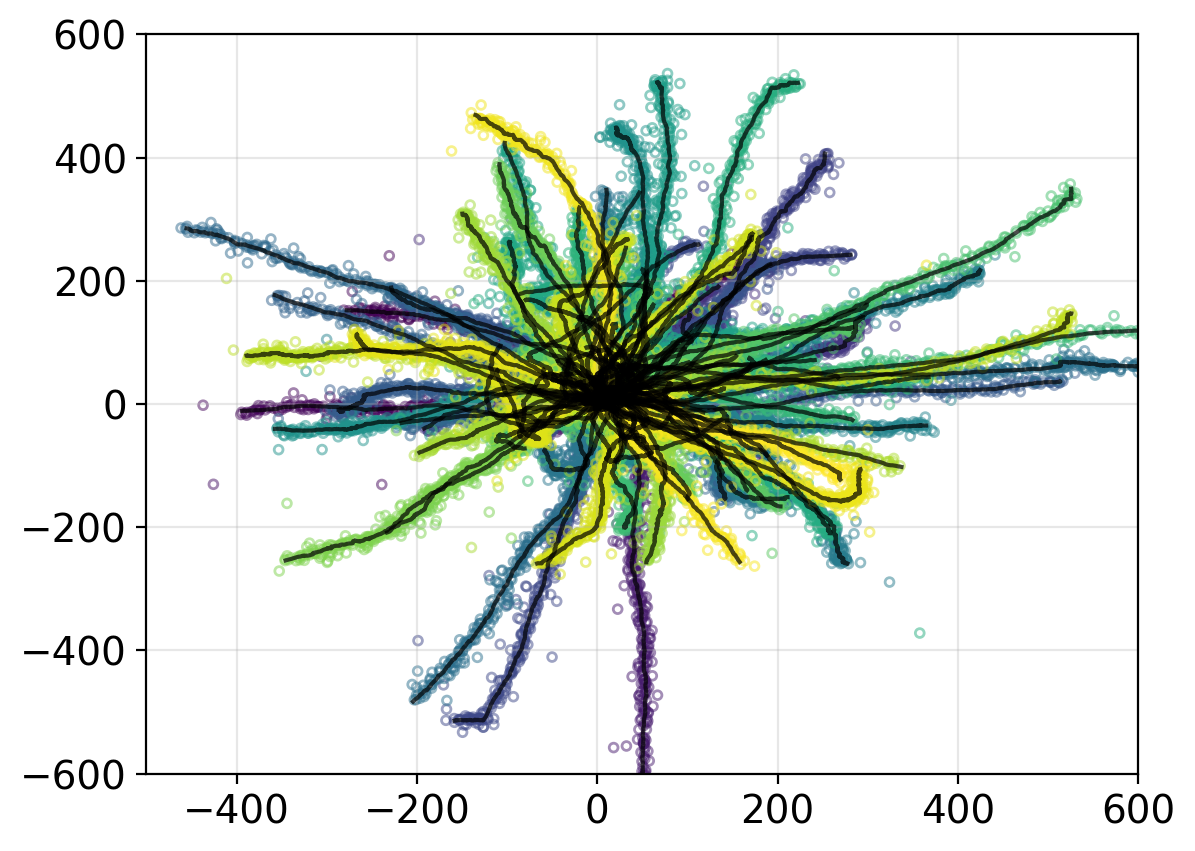

In [7]:
for i, color in enumerate(colors):
    dataset = jax.tree_map(lambda x: np.array(x[i]), datasets)
    plt.plot(*dataset["latent"][:, :2].T, c="black", alpha=0.7)
    plt.scatter(*dataset["observed"].T, edgecolor=color, color="none", s=10, alpha=0.5)
    plt.grid(alpha=0.3)
    
plt.xlim(-500, 600)
plt.ylim(-600, 600)

## WSM filter

In [8]:
agent_wsm = gbf.WSMFilter(
    link,
    suff_stat,
    log_base_measure,
    dynamics_covariance=dgen.dynamics_covariance,
    weighting_function=partial(imq_kernel, c=6),
    transition_matrix=dgen.transition_matrix
)

In [9]:
init_bel = agent_wsm.init_bel(initial_mean, cov=1.0)

vscan = jax.vmap(
    partial(agent_wsm.scan, callback_fn=callbacks.get_updated_mean),
    in_axes=(None, 0, None, None)
)
_, hist_bel_wsm_runs = vscan(
    init_bel, yv, jnp.ones(n_steps), 1.0, 
)

In [10]:
diff_wsm = jnp.abs(hist_bel_wsm_runs - datasets["latent"])
diff_wsm.sum(axis=1).mean(axis=0)

Array([662.4883, 658.6872, 631.185 , 618.3041], dtype=float32)

## Kalman filter

In [11]:
agent_kf = kf.KalmanFilter(
    dgen.transition_matrix,
    dgen.dynamics_covariance,
    dgen.observation_covariance
)


init_bel = agent_kf.init_bel(initial_mean, cov=1.0)

vscan = jax.vmap(
    partial(agent_kf.scan, callback_fn=callbacks.get_updated_mean),
    in_axes=(None, 0, None)
)
_, hist_bel_kf_runs = vscan(
    init_bel, yv, dgen.projection_matrix
)

In [12]:
diff_kf = jnp.abs(hist_bel_kf_runs - datasets["latent"])
diff_kf.sum(axis=1).mean(axis=0)

Array([1013.53436, 1073.9187 ,  755.4381 ,  767.01215], dtype=float32)

## Robust KF

In [13]:
agent_rkf = kf.RobustKalmanFilter(
    dgen.transition_matrix,
    dgen.dynamics_covariance,
    dgen.observation_covariance,
    n_inner=1,
    noise_scaling=20.0
)


In [14]:
init_bel = agent_rkf.init_bel(initial_mean, cov=1.0)

vscan = jax.vmap(
    partial(agent_rkf.scan, callback_fn=callbacks.get_updated_mean),
    in_axes=(None, 0, None)
)
_, hist_bel_rkf_runs = vscan(
    init_bel, yv, dgen.projection_matrix
)

In [15]:
diff_rkf = jnp.abs(hist_bel_rkf_runs - datasets["latent"])
diff_rkf.sum(axis=1).mean(axis=0)

Array([883.6664 , 901.7913 , 705.05286, 693.1261 ], dtype=float32)

## Student-t filter

In [16]:
agent_stf = stf.LinearFilter(
    dgen.transition_matrix,
    dgen.dynamics_covariance,
    dgen.observation_covariance,
    dof_latent=dof,
    dof_observed=100
)

init_bel = agent_stf.init_bel(initial_mean, scale=0.01, dof=5.0)

vscan = jax.vmap(
    partial(agent_stf.scan, callback_fn=callbacks.get_updated_mean),
    in_axes=(None, 0, None)
)
_, hist_bel_stf_runs = vscan(
    init_bel, yv, dgen.projection_matrix
)

In [17]:
diff_stf = jnp.abs(hist_bel_stf_runs - datasets["latent"])
diff_stf.sum(axis=1).mean(axis=0)

Array([1498.4003, 1525.1769, 3054.6572, 3133.8242], dtype=float32)

## Weighted (IMQ) Kalman Filter

In [18]:
agent_imq = gbf.IMQFilter(
    link,
    dynamics_covariance=dgen.dynamics_covariance,
    observation_covariance=dgen.observation_covariance,
    soft_threshold=14,
    transition_matrix=dgen.transition_matrix,
)

init_bel = agent_imq.init_bel(initial_mean, cov=1.0)
vscan = jax.vmap(
    partial(agent_imq.scan, callback_fn=callbacks.get_updated_mean),
    in_axes=(None, 0, None)
)


_, hist_bel_imq_runs = vscan(
    init_bel, yv, jnp.ones(n_steps)
)

In [19]:
diff_imq = jnp.abs(hist_bel_imq_runs - datasets["latent"])
diff_imq.sum(axis=1).mean(axis=0)

Array([667.54004, 680.29193, 616.90283, 607.2354 ], dtype=float32)

## Plot comparison

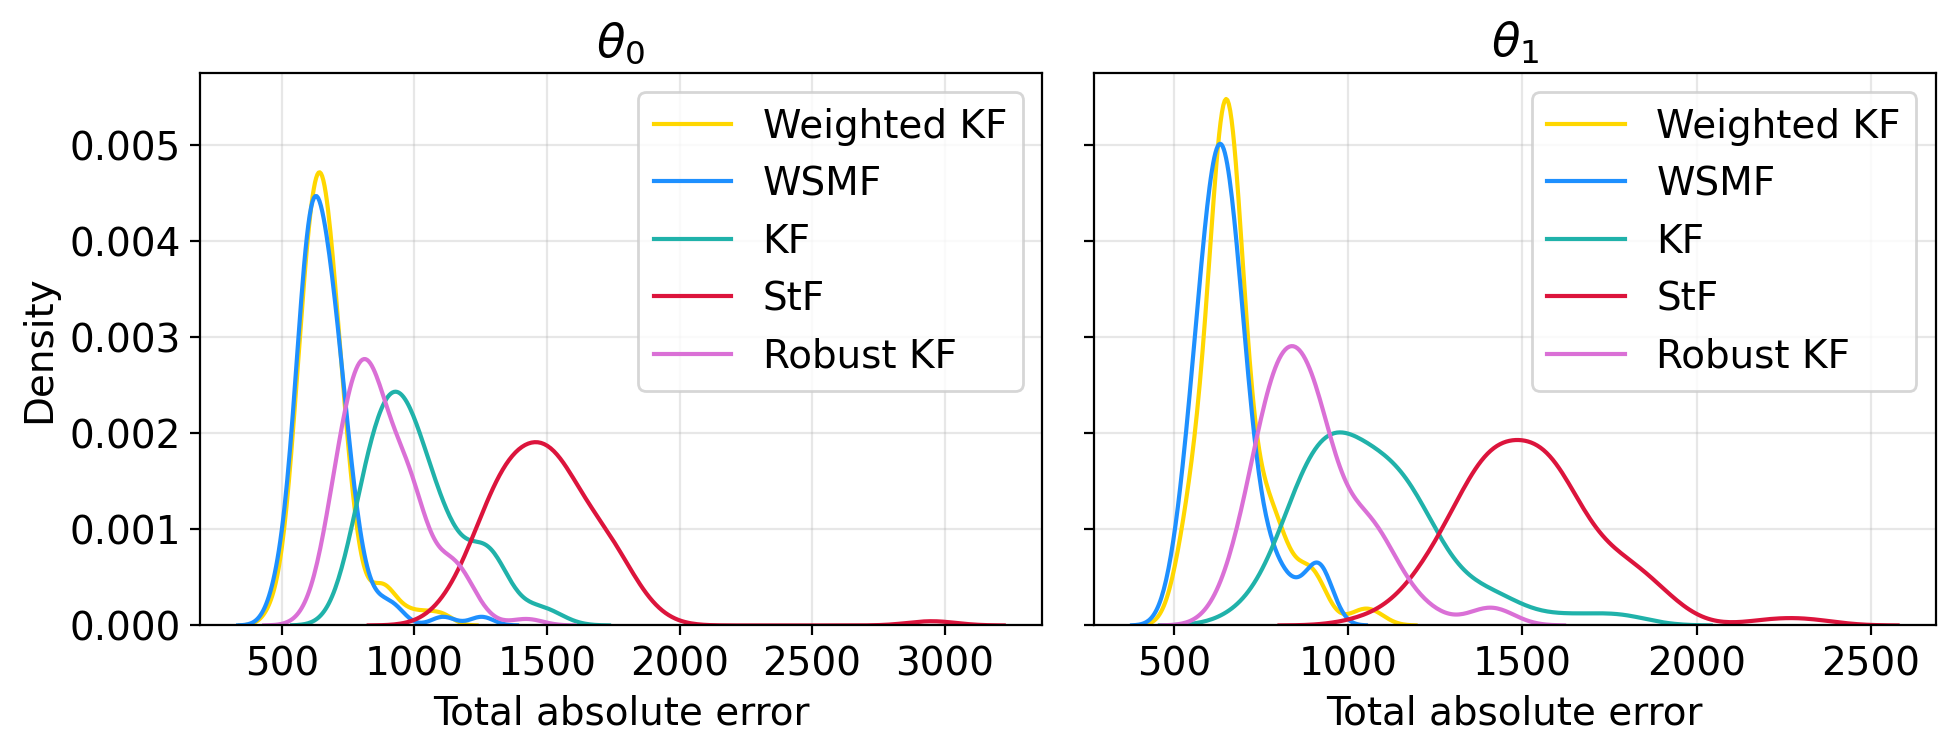

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

for i in range(2):
    sns.kdeplot(diff_imq.sum(axis=1)[:, i], color="gold", label="Weighted KF", ax=ax[i])
    sns.kdeplot(diff_wsm.sum(axis=1)[:, i], color="dodgerblue",label="WSMF", ax=ax[i])
    sns.kdeplot(diff_kf.sum(axis=1)[:, i], color="lightseagreen", label="KF", ax=ax[i])
    sns.kdeplot(diff_stf.sum(axis=1)[:, i], color="crimson", label="StF", ax=ax[i])
    sns.kdeplot(diff_rkf.sum(axis=1)[:, i], color="orchid", label="Robust KF", ax=ax[i])
    ax[i].set_title(fr"$\theta_{i}$")
    ax[i].legend()
    ax[i].set_xlabel("Total absolute error")
    ax[i].grid(alpha=0.3)
plt.tight_layout()
plt.savefig("./2d-ssm-comparison.pdf")

## Single model comparison

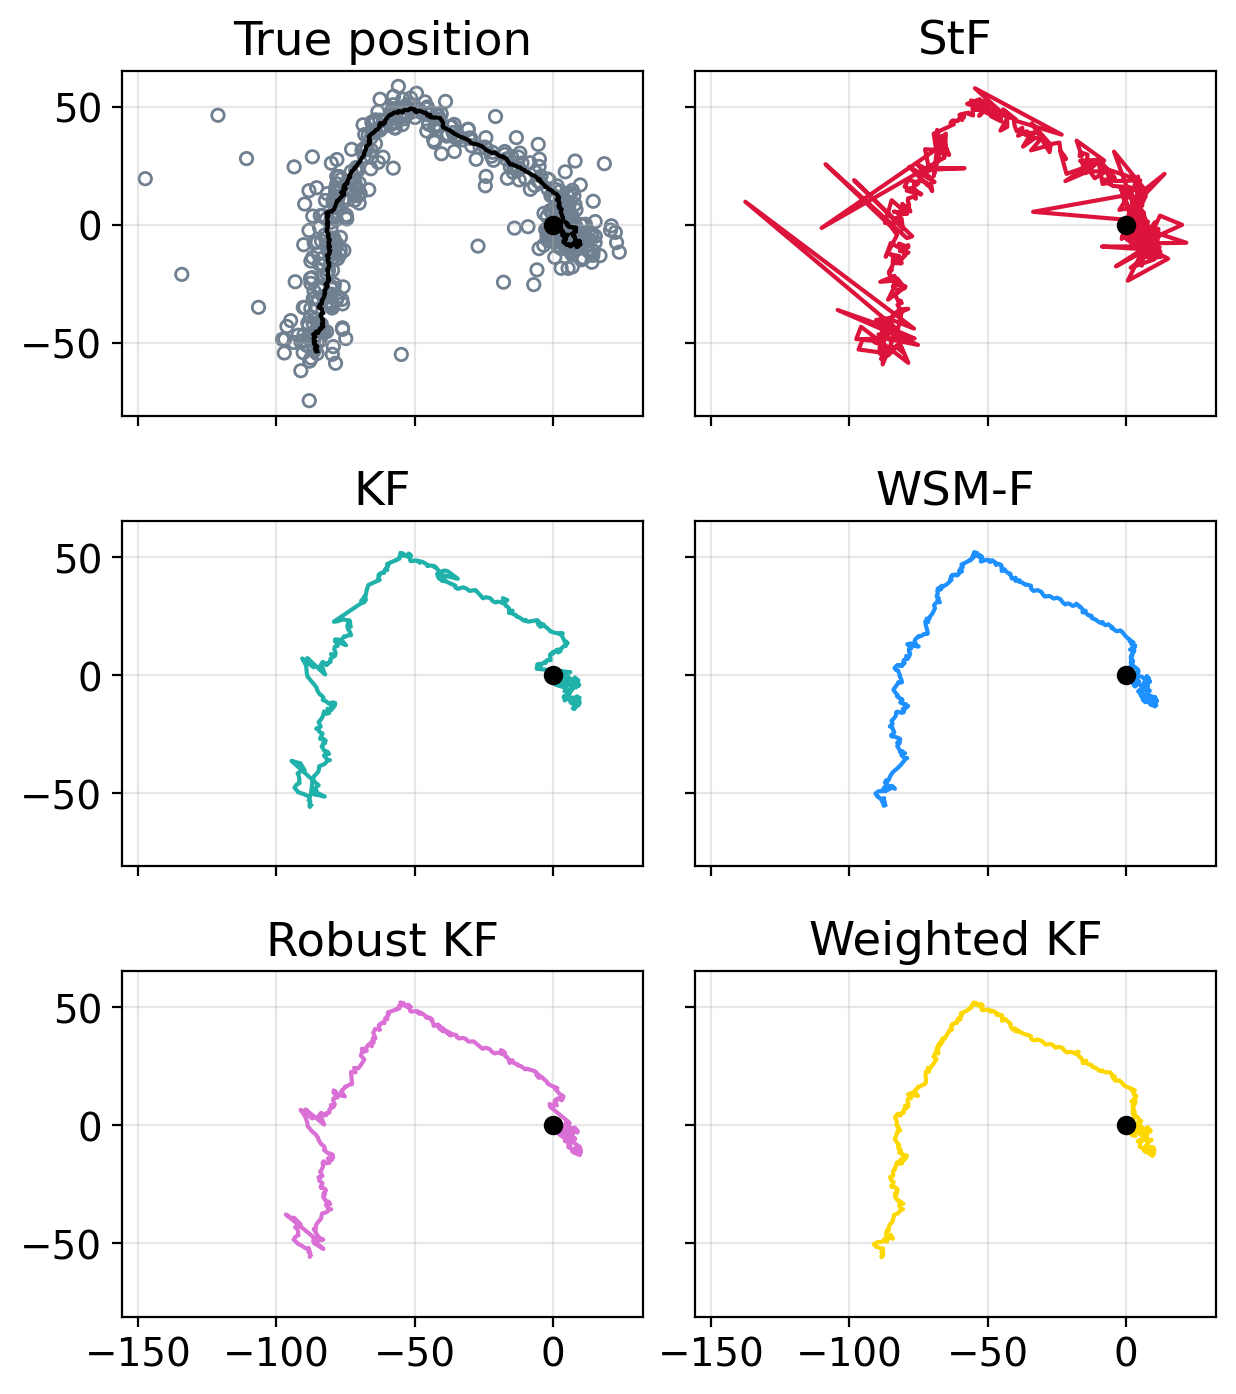

In [21]:
i = 6
# i = 7
# i = 12
latent_i = datasets["latent"][i, :, :2].T
kf_i = hist_bel_kf_runs[i, :, :2].T
stf_i = hist_bel_stf_runs[i, :, :2].T
wsm_i = hist_bel_wsm_runs[i, :, :2].T
rkf_i = hist_bel_rkf_runs[i, :, :2].T
imq_i = hist_bel_imq_runs[i, :, :2].T

fig, ax = plt.subplots(3,2, figsize=(6.4, 7.2), sharex=True, sharey=True)

ax[0,0].plot(*latent_i, c="black")
ax[0,0].set_title("True position")
ax[0,0].scatter(*yv[i, :].T, edgecolor="slategray", color="none", s=20, label="observed")

ylim = ax[0,0].get_ylim()
xlim = ax[0,0].get_xlim()

ax[1,0].plot(*kf_i, c="lightseagreen")
ax[1,0].set_title("KF")

ax[0,1].plot(*stf_i, c="crimson")
ax[0,1].set_title("StF")

ax[1,1].plot(*wsm_i, c="dodgerblue")
ax[1,1].set_title("WSM-F")


ax[2,0].plot(*rkf_i, c="orchid")
ax[2,0].set_title("Robust KF")

ax[2,1].plot(*imq_i, c="gold")
ax[2,1].set_title("Weighted KF")


for axi in ax.ravel():
    axi.grid(alpha=0.3)
    axi.scatter(0,0, c="black", zorder=3)
    # axi.set_ylim(*ylim)
    # axi.set_xlim(*xlim)
plt.tight_layout()
plt.savefig("./2d-ssm-comparison-single-run.pdf")

## Ablation:
### What happens to WSM when there is no weight function?

In [22]:
def identity_kernel(y, mean, x, linkfn=None):
    yhat = linkfn(mean, x)
    return jnp.eye(len(yhat))

In [23]:
agent_wsm = gbf.WSMFilter(
    link,
    suff_stat,
    log_base_measure,
    dynamics_covariance=dgen.dynamics_covariance,
    weighting_function=identity_kernel,
    transition_matrix=dgen.transition_matrix
)

In [24]:
init_bel = agent_wsm.init_bel(initial_mean, cov=1.0)

vscan = jax.vmap(
    partial(agent_wsm.scan, callback_fn=callbacks.get_updated_mean),
    in_axes=(None, 0, None, None)
)
_, hist_bel_wsm_runs = vscan(
    init_bel, yv, jnp.ones(n_steps), 1.0, 
)

In [25]:
diff_wsm = jnp.abs(hist_bel_wsm_runs - datasets["latent"])
diff_wsm.sum(axis=1).mean(axis=0)

Array([1307.1655, 1329.2166, 2318.4792, 2251.5752], dtype=float32)

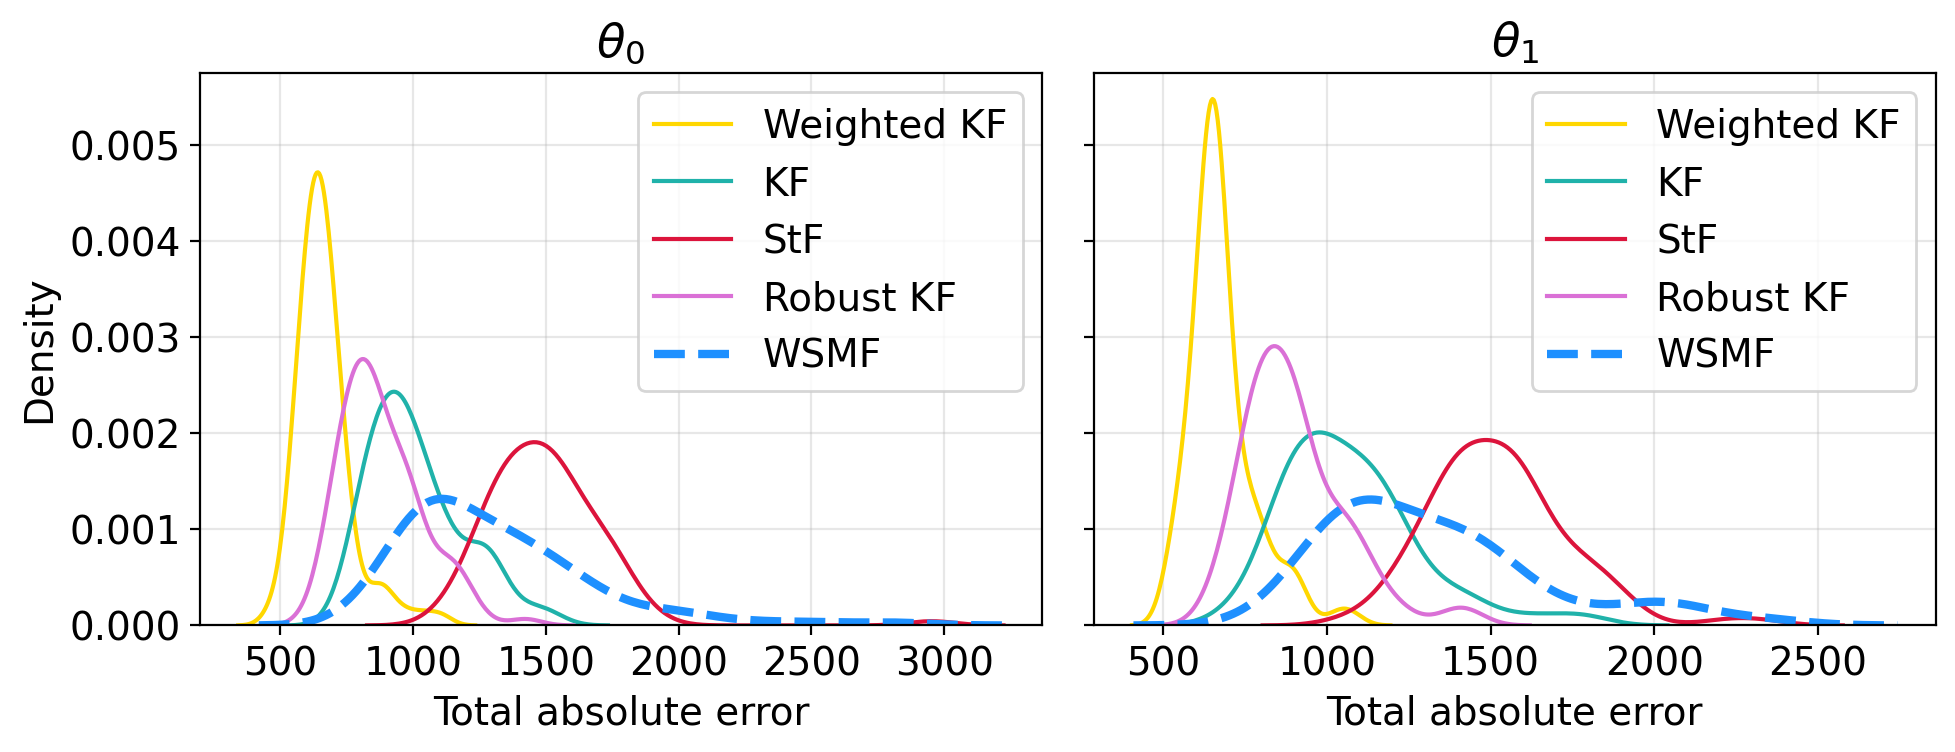

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

for i in range(2):
    sns.kdeplot(diff_imq.sum(axis=1)[:, i], color="gold", label="Weighted KF", ax=ax[i])
    sns.kdeplot(diff_kf.sum(axis=1)[:, i], color="lightseagreen", label="KF", ax=ax[i])
    sns.kdeplot(diff_stf.sum(axis=1)[:, i], color="crimson", label="StF", ax=ax[i])
    sns.kdeplot(diff_rkf.sum(axis=1)[:, i], color="orchid", label="Robust KF", ax=ax[i])
    sns.kdeplot(diff_wsm.sum(axis=1)[:, i], color="dodgerblue",label="WSMF", ax=ax[i], linewidth=3, linestyle="--")
    ax[i].set_title(fr"$\theta_{i}$")
    ax[i].legend()
    ax[i].set_xlabel("Total absolute error")
    ax[i].grid(alpha=0.3)
plt.tight_layout()
plt.savefig("./2d-ssm-comparison.pdf")

Roth, Algamenon, VB approach.

## Ablation:
## Does weighted KF converge to KF when there is no weight function?

## Kalman filter

In [28]:
agent_kf = kf.KalmanFilter(
    dgen.transition_matrix,
    dgen.dynamics_covariance,
    dgen.observation_covariance
)


init_bel = agent_kf.init_bel(initial_mean, cov=1.0)

vscan = jax.vmap(
    partial(agent_kf.scan, callback_fn=callbacks.get_updated_mean),
    in_axes=(None, 0, None)
)
_, hist_bel_kf_runs = vscan(
    init_bel, yv, dgen.projection_matrix.astype(float)
)

In [29]:
diff_kf = jnp.abs(hist_bel_kf_runs - datasets["latent"])
diff_kf.sum(axis=1).mean(axis=0)

Array([1013.53436, 1073.9187 ,  755.4381 ,  767.01215], dtype=float32)

In [30]:
diff_kf.sum(axis=1).std(axis=0)

Array([174.68343, 208.4803 , 148.32976, 160.80446], dtype=float32)

## Weighted (IMQ) Kalman Filter

In [62]:
def link(z, _):
    mean = dgen.projection_matrix @ z
    return mean

In [63]:
agent_imq = gbf.IMQFilter(
    link,
    dynamics_covariance=dgen.dynamics_covariance,
    observation_covariance=dgen.observation_covariance,
    soft_threshold=1e6,
    transition_matrix=dgen.transition_matrix
)

init_bel = agent_imq.init_bel(initial_mean, cov=1.0)
vscan = jax.vmap(
    partial(agent_imq.scan, callback_fn=callbacks.get_updated_mean),
    in_axes=(None, 0, None)
)


_, hist_bel_imq_runs = vscan(
    init_bel, yv, jnp.ones(n_steps)
)

In [64]:
diff_imq = jnp.abs(hist_bel_imq_runs - datasets["latent"])
diff_imq.sum(axis=1).mean(axis=0)

Array([1014.65826, 1074.2965 ,  758.3904 ,  768.48694], dtype=float32)

In [65]:
(diff_imq.sum(axis=1) - diff_kf.sum(axis=1)).mean(axis=0)

Array([1.123952 , 0.3779651, 2.9523623, 1.4747968], dtype=float32)

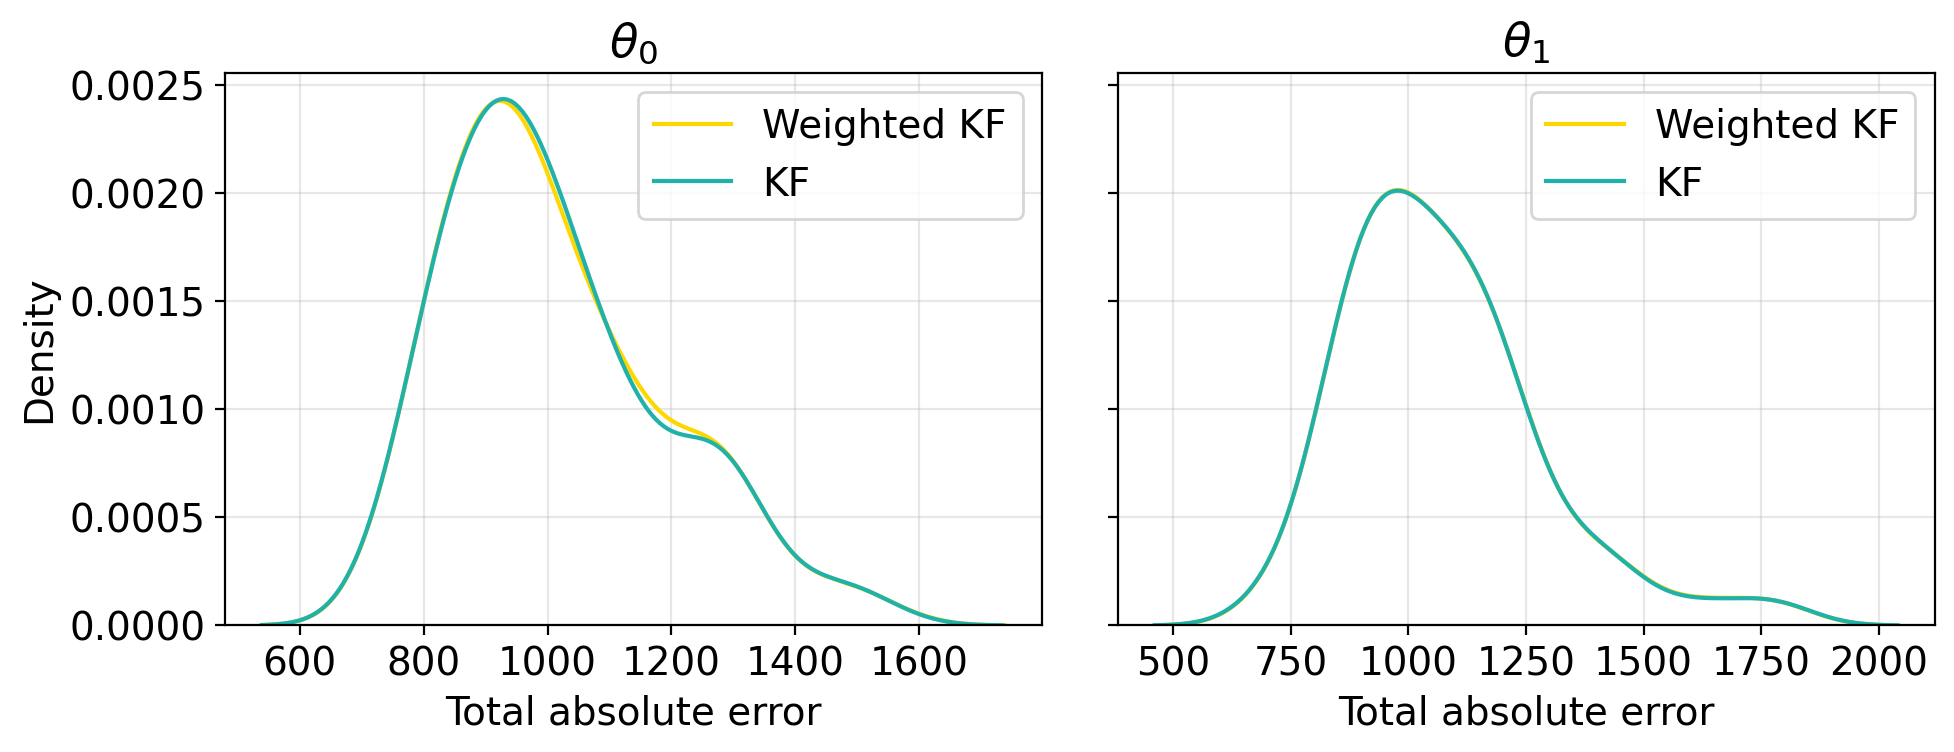

In [66]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

for i in range(2):
    sns.kdeplot(diff_imq.sum(axis=1)[:, i], color="gold", label="Weighted KF", ax=ax[i])
    sns.kdeplot(diff_kf.sum(axis=1)[:, i], color="lightseagreen", label="KF", ax=ax[i])
    ax[i].set_title(fr"$\theta_{i}$")
    ax[i].legend()
    ax[i].set_xlabel("Total absolute error")
    ax[i].grid(alpha=0.3)
plt.tight_layout()
plt.savefig("./2d-ssm-comparison.pdf")

## Varying `soft_threshold`

In [67]:
thresholds = [0.01, 0.1, 0.5, 1.0, 2.0, 5.0]
colors = np.linspace(0, 1, len(thresholds))
colors = plt.cm.viridis(colors)

In [68]:
diffs = {}
for threshold in thresholds:
    agent_imq = gbf.IMQFilter(
        link,
        dynamics_covariance=dgen.dynamics_covariance,
        observation_covariance=dgen.observation_covariance,
        soft_threshold=threshold,
        transition_matrix=dgen.transition_matrix
    )

    init_bel = agent_imq.init_bel(initial_mean, cov=1.0)
    vscan = jax.vmap(
        partial(agent_imq.scan, callback_fn=callbacks.get_updated_mean),
        in_axes=(None, 0, None)
    )


    _, hist_bel_imq_runs = vscan(
        init_bel, yv, jnp.ones(n_steps)
    )

    diff_imq = jnp.abs(hist_bel_imq_runs - datasets["latent"])[..., :-2]
    diffs[threshold] = diff_imq

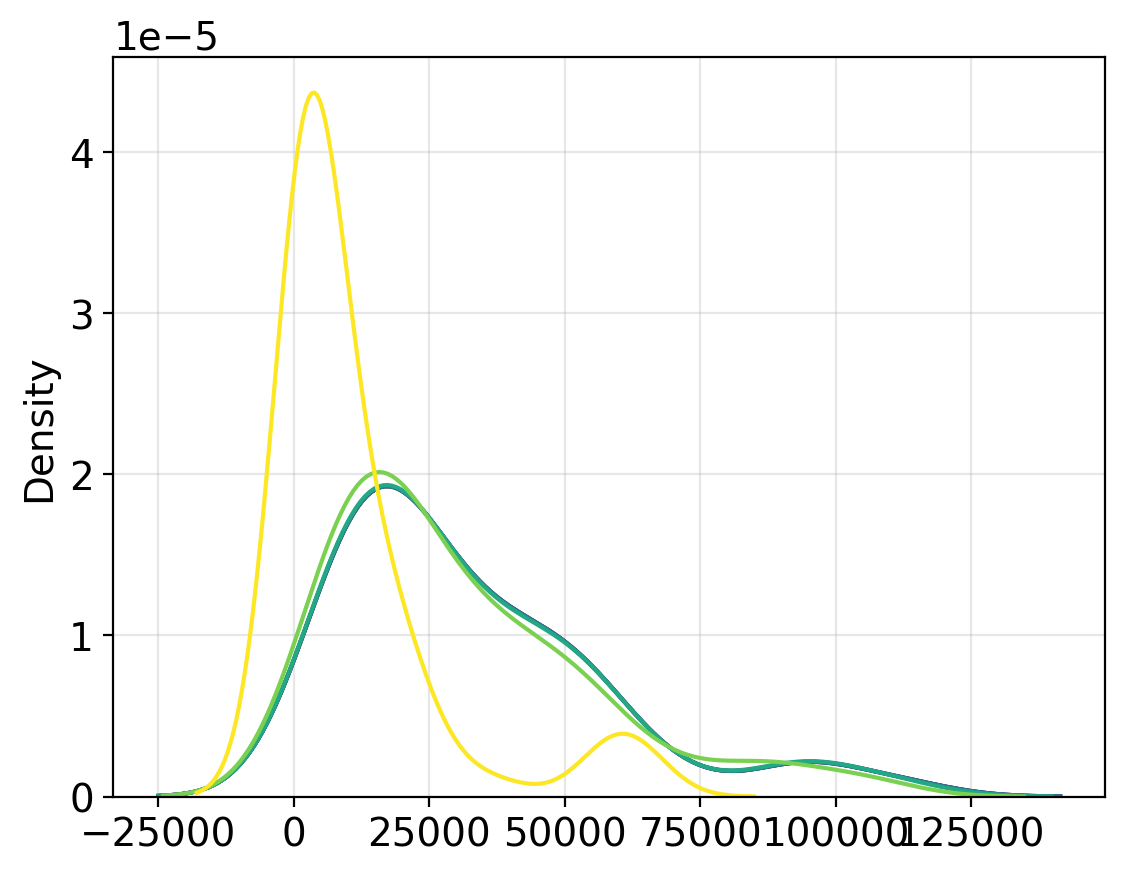

In [69]:
fig, ax = plt.subplots()
for threshold, color in zip(thresholds, colors):
    diff_imq = diffs[threshold]
    sns.kdeplot(diff_imq.sum(axis=1)[:, 1], color=color)
plt.grid(alpha=0.3)